In [1]:
%store -r __import

In [2]:
__import

In [3]:
import datetime
import warnings
from itertools import product
import gc

import catboost
from catboost import Pool
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
sales = pd.read_csv('/home/tuts/datasets/how_to_win/sales_train.csv')
shops = pd.read_csv('/home/tuts/datasets/how_to_win/shops.csv')
items = pd.read_csv('/home/tuts/datasets/how_to_win/items.csv')
item_cats = pd.read_csv('/home/tuts/datasets/how_to_win/item_categories.csv')
test = pd.read_csv('/home/tuts/datasets/how_to_win/test.csv')

In [5]:
train = sales.join(shops, on='shop_id', rsuffix='_').join(items, on='item_id', rsuffix='_').join(item_cats, on='item_category_id', rsuffix='_').drop(['shop_id_', 'item_category_id_', 'item_id_'], axis=1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.00,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.00,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.00,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.00,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [7]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [8]:
print(f'min date {train.date.min()}')
print(f'max date {train.date.max()}')

min date 2013-01-01 00:00:00
max date 2015-10-31 00:00:00


In [9]:
test_shop_ids = test.shop_id.unique()
test_item_ids = test.item_id.unique()
train = train[train.shop_id.isin(test_shop_ids)]
train = train[train.item_id.isin(test_item_ids)]

In [10]:
train.shape

(1224439, 10)

In [11]:
train_features = ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']
train_month = train[train_features]

In [12]:
gb = train_month.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
gb = gb.agg({'item_price': ['sum', 'mean'], 'item_cnt_day': ['sum', 'mean', 'count']})
gb.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price_sum', 'mean_item_price', 'item_cnt_sum', 'mean_item_cnt_mean', 'item_cnt_count']

In [13]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

In [14]:
train_month = pd.merge(grid, gb, on=['date_block_num','shop_id','item_id'], how='left')
train_month.fillna(0, inplace=True)

In [15]:
train_month.head()

,shop_id,item_id,date_block_num,item_category_id,item_price_sum,mean_item_price,item_cnt_sum,mean_item_cnt_mean,item_cnt_count
0,59,22154,0,37.00,999.00,999.00,1.00,1.00,1.00
1,59,2552,0,0.00,0.00,0.00,0.00,0.00,0.00
2,59,2554,0,0.00,0.00,0.00,0.00,0.00,0.00
3,59,2555,0,0.00,0.00,0.00,0.00,0.00,0.00
4,59,2564,0,0.00,0.00,0.00,0.00,0.00,0.00


In [16]:
del grid, gb
gc.collect();

In [17]:
train_month.to_csv('train_month.csv', index=False)

In [18]:
train_month.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,10913850.00,31.19,17.35,0.00,16.00,30.00,46.00,59.00
item_id,10913850.00,11309.26,6209.98,0.00,5976.00,11391.00,16605.00,22169.00
date_block_num,10913850.00,14.97,9.50,0.00,7.00,14.00,23.00,33.00
item_category_id,10913850.00,2.34,10.54,0.00,0.00,0.00,0.00,83.00
item_price_sum,10913850.00,115.63,1712.87,0.00,0.00,0.00,0.00,515573.59
mean_item_price,10913850.00,50.12,421.90,0.00,0.00,0.00,0.00,42990.00
item_cnt_sum,10913850.00,0.15,2.72,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt_mean,10913850.00,0.06,0.48,-2.00,0.00,0.00,0.00,1000.00
item_cnt_count,10913850.00,0.11,0.72,0.00,0.00,0.00,0.00,31.00


In [19]:
train_month['year'] = train_month.date_block_num.apply(lambda x: (x // 12)+2013)
train_month['month'] = train_month.date_block_num.apply(lambda x: (x % 12))

In [22]:
train_month.year.unique()

array([2013, 2014, 2015])

In [21]:
train_month.month.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [23]:
gb_month_sales = train_month[['month', 'item_cnt_count']].groupby('month', as_index=False).mean()
gb_month_sales.head()

,month,item_cnt_count
0,0,0.10
1,1,0.10
2,2,0.10
3,3,0.09
4,4,0.10


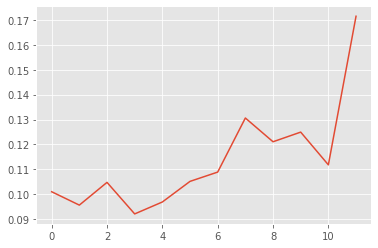

In [24]:
plt.plot(gb_month_sales.month, gb_month_sales.item_cnt_count);